In [1]:
"""Plot the pickles produced by poster_astrometry.py
"""
from pathlib import Path
import os
import pickle

import numpy as np

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')  # noqa: E402
seaborn.set_context("poster")  # noqa: E402
import itertools  

import time

---install line profiler

In [17]:
def uv_mean(width, height, xx, yy, uu, vv, nx, ny):
    """Compute the mean of uu and vv on a grid within bbox."""
    #nx = 30    These have now been placed as parameters
    #ny = 60
    uMean = np.zeros((nx-1, ny-1))
    vMean = np.zeros((nx-1, ny-1))
    xMean = np.zeros((nx-1, ny-1))
    yMean = np.zeros((nx-1, ny-1))
    ww = np.linspace(xlim[0], xlim[1], nx)
    hh = np.linspace(ylim[0], ylim[1], ny)
    xrange = np.array([((xx >= w0) & (xx <= w1)) for w0, w1 in zip(ww[:-1], ww[1:])], dtype=bool)
    yrange = np.array([((yy >= w0) & (yy <= w1)) for w0, w1 in zip(hh[:-1], hh[1:])], dtype=bool)
    for i, (w0, w1) in enumerate(zip(ww[:-1], ww[1:])):
        for j, (h0, h1) in enumerate(zip(hh[:-1], hh[1:])):
            inside = xrange[i] & yrange[j]
            xMean[i, j] = (w0 + w1)/2
            yMean[i, j] = (h0 + h1)/2
            uMean[i, j] = np.mean(uu[inside]) #np slicing 
            vMean[i, j] = np.mean(vv[inside])

    return xMean, yMean, uMean, vMean


def plot_quiver(xx, yy, uu, vv, ccd, label):
    """Make a quiver plot of the astrometry error vectors."""
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    color = cycle[0] if 'jointcal' in label else cycle[1]
    scale = 0.25 if 'mean' in label else 1

    fig = plt.figure(figsize=(6, 10))
    ax = fig.add_subplot(111)
    
    angle = np.nan_to_num(np.arctan2(vMean,uMean))
    Q = ax.quiver(xx, yy, uu, vv, angle, cmap='twilight_shifted', units='x', pivot='tail', scale=scale, width=7,
                  headwidth=4, clip_on=False)
    #Q = ax.quiver(xx, yy, uu, vv, units='x', pivot='tail', scale=scale, width=7,
    #              headwidth=4, clip_on=False, color=color)
    length = 5/scale if 'mean' in label else 100
    key = ax.quiverkey(Q, 0.20, 0.10, length, '%s mas'%(length), angle=45,
                       coordinates='figure', labelpos='W', fontproperties={'size': 24})

    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    fig.subplots_adjust()
    plt.show();

    filename = Path("plots/quiver-%s-%s.png"%(ccd, label))
#    plt.savefig(filename, bbox_extra_artists=(key,))# bbox_inches="tight")
#    plt.close(fig)

In [18]:
#name = 'single'
name = 'jointcal'
file_name = os.path.abspath('focalplane/%s/pickles/quiverData-%s-6.pickle'%(name,name)) 

#openfile = open(file_name, 'rb')     #original from John
#xx, yy, uu, vv, bbox, ccd = pickle.load(openfile)

with open(os.path.expanduser(file_name), 'rb') as infile:
    #xx, yy, uu, vv, width, height, ccd = pickle.load(infile)
    xx, yy, uu, vv, xlim, ylim, ccd = pickle.load(infile)

C:\Users\Short Stack\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Short Stack\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


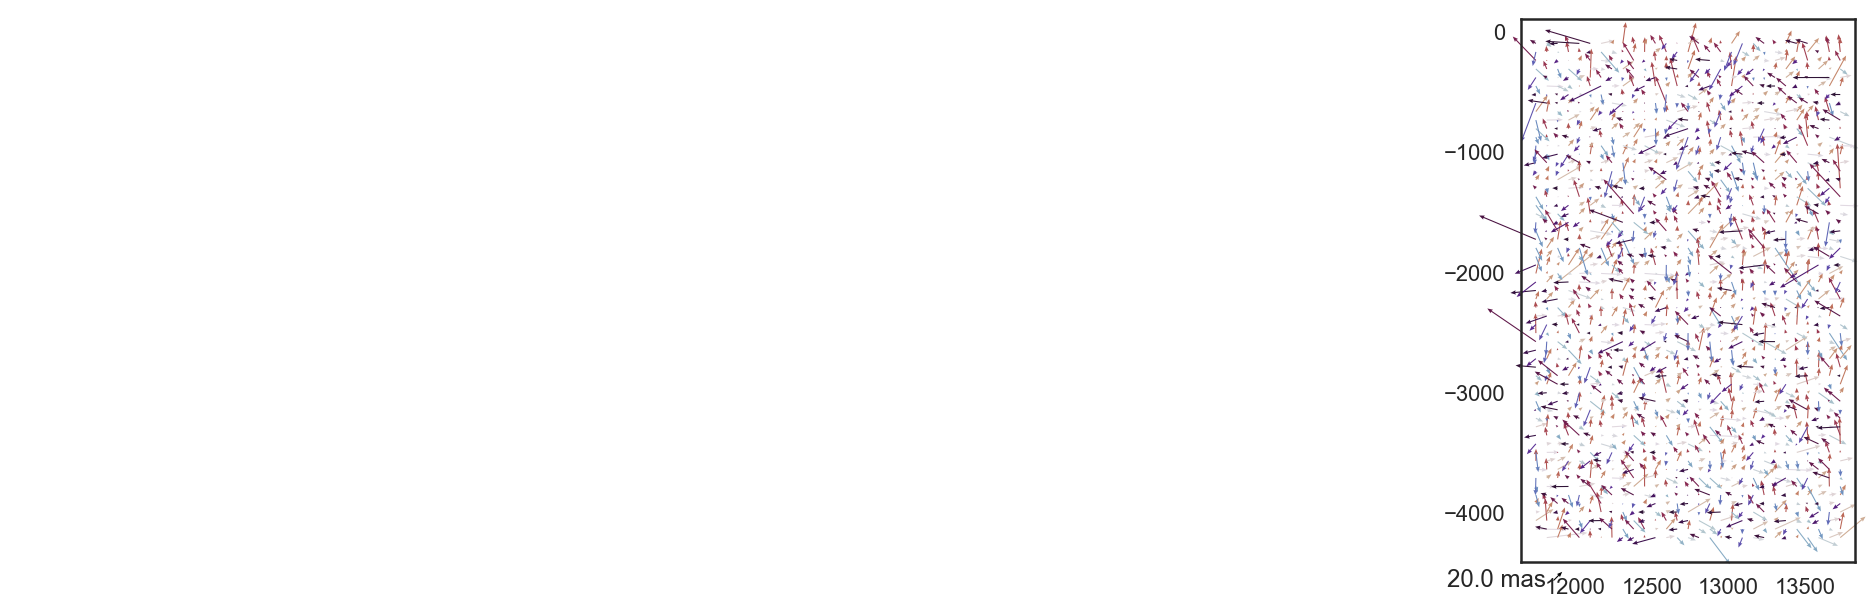

In [19]:

xMean, yMean, uMean, vMean = uv_mean(xlim, ylim, xx, yy, uu, vv, 30, 60)

#plot_quiver(xx, yy, uu, vv, ccd, name)

plot_quiver(xMean, yMean, uMean, vMean, ccd, 'mean-'+name)



In [39]:
%timeit uv_mean(xlim, ylim, xx, yy, uu, vv, 30, 60)

58 ms ± 783 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%timeit uv_mean(xlim, ylim, xx, yy, uu, vv, 30, 60)

82.9 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


-Reproduce in bokeh (and matplotlib {sliders??}) 



In [45]:
#functioning
"""
Bokeh Quiver plot using segment()
"""
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, ColorBar, tools
import bokeh.palettes as palettes 
from bokeh.transform import linear_cmap
import astropy.units as u

import holoviews as hv

In [46]:
arcsecperpix = .17

def bokeh_qplot(xx, yy, uu, vv):
    #data for plot
    x0 = xMean.flatten()
    y0 = yMean.flatten()
    length = np.nan_to_num(np.sqrt(uMean**2 + vMean**2)) * u.arcsec
    angle = np.nan_to_num(np.arctan2(vMean,uMean))
    angle_deg = angle*180/np.pi
    
    x1 = (xMean + length.value/arcsecperpix * np.cos(angle)).flatten()
    y1 = (yMean + length.value/arcsecperpix * np.sin(angle)).flatten()

    slopes = []
    for i in range(len(x0)):
        m = (y1[i]-y0[i])/(x1[i]-x0[i])
        slopes.append(m)

    #line coloring
    pal = palettes.cividis(21)
    cm = np.array(pal) 
    ix = ((angle-angle.min())/(angle.max()-angle.min())*20).astype('int') #normalizing 
    colors = cm[ix].flatten()



    #data frame setup
    source = ColumnDataSource(data={
        'x0'     : x0,
        'y0'     : y0,
        'x1'     : x1,
        'y1'     : y1,
        'slopes' : np.asarray(slopes),
        'angle'  : np.asarray(angle* 180/np.pi),
        'length' : np.asarray(length),
        'color'  : np.asarray(colors)
    })
    TOOLTIPS = [
        ("(x0,y0)", "(@x0{1.11}, @y0{1.11})"), #{1.11} formats as 2 decimal float
        ("(x1,y1)", "(@x1{1.11}, @y1{1.11})"),
        ("Length", "@length{%s}"), ###get astropy.units to print out
        ("Angle (deg)", "@angle{1.111}"),
    ]
    hover = tools.HoverTool(
        tooltips = TOOLTIPS,
        formatters = {
            "length" : "printf"
        }

    )


    p1 = figure( title="%s Data"%name)

    p1.title.text_font_size = "50px"
    p1.add_tools(hover)
    p1.segment('x0', 'y0', 'x1', 'y1', color='color', line_width=2, source=source, legend='unit')

    mapper = linear_cmap(field_name='angle', palette=pal ,low=min(angle_deg.flatten()) ,high=max(angle_deg.flatten()))
    color_bar = ColorBar(color_mapper=mapper['transform'], width=12,  location=(0,0))

    p1.add_layout(color_bar, 'right')

    output_file("BokehSegmentVector.html", title="BokehSegmentVector (%s)"%name)

    show(p1) 

In [50]:
#print(hv['twilight_shifted'][11])

In [47]:
bokeh_qplot(xMean, yMean, uMean, vMean)

C:\Users\Short Stack\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


-Cyclic Bokeh colormap 

-legend (with actual unit size) {Cant find anything that can do this???}


--Divergence and curl as another plot

# Divergence

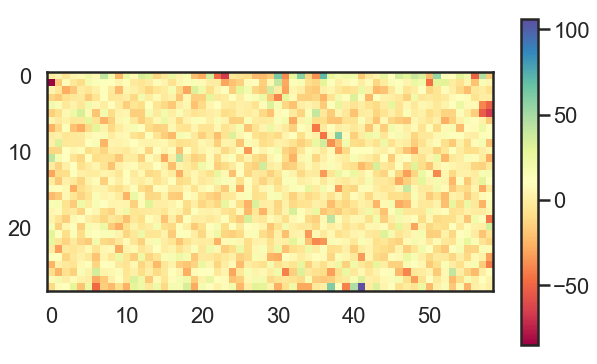

In [49]:
uDiv = np.nan_to_num(np.gradient(uMean))
vDiv = np.nan_to_num(np.gradient(vMean))
divergence = uDiv[1]+vDiv[0]
plt.figure(figsize=(10,6))
plt.imshow(divergence, cmap="Spectral")
#plt.contourf(xMean,yMean,(uDiv[1]+vDiv[0]))
plt.colorbar()
#cbar.set_label("")

#at a given point slope of field at the give point
#slopeu = avg(uMean[i-1],u[i+1]) #maybe fit a line through the point ignoriong edges uMean[1] to uMean[-1]
#slopev = avg(vMean[i-1],v[i+1])